# Managing Innovation

Solution developed for group 4 based on the requirement specification. 

In addition to this notebook, a folder named `output` can be found. This folder contains the plots produced in this notebook. Furthermore it holds an excel file with the additonal variables added in this notebook (e.g., mean sentiment score, score of the idea and the rank)

Additionally, some functions written for this task can be found in `helper_functions.py`.


#### Requirement specification

Variables that assess the quality of an idea (Total of 100%):
* Number of votes (50%)
* Selected by an expert (25%)
* How positive is the comment (mean of all comments on idea) * number of upvotes on that comment (25%)


Compare quality with:​
* The grammar of the body of the idea
* Prior experience
* Departments
* Country


10 best vs 10 worst in the end, and then we can qualitatively assess whether our model is working or not.

#### Contact information
Code by Laura Bock Paulsen (202005791@post.au.dk)

Group 4: feel free to reach out if you have any questions

To ensure you have all the dependencies, run the following chunk.

In [75]:
#! pip install --user -U nltk
#nltk.download()

Then all the functions and packages needed for the task are loaded.

In [76]:
from nltk.corpus import stopwords
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
import pandas as pd
import numpy as np
from helper_functions import *

Then the data is imported. For a overview of the data, go to the `data_exploration.ipynb` in the main folder. 

In [77]:
(ideas, comments, ideator) = read_data()

The idea sheet had a problem with some characters not being displayed right. This is remedied by the following code. 

In [78]:
ideas['Body'] = ideas['Body'].str.encode('ascii', errors='ignore')
ideas['Body'] = ideas['Body'].str.decode("utf-8")

In [79]:
for i in range(len(ideas)):
    print(ideas['Body'][i] + '\n')

Often I see a LEGO box get torn open because it is not obvious how to open it without damaging it. I think it would be nice if there was an easier way to open the box.

When taking visitors through the Idea House I have often observed how people become quiet and reflective, even slightly emotional when they see models launched during their own childhood. Might there be a way we can get people to reconnect with their childhood in our Brand Stores? I would think that most would be more prone to buy products for their children (or for themselves for that matter) when in that frame of mind..."

Hi :) During the christmas holiday  I was playing with LEGO City together with my nephew (4 years old). Suddenly he asked me how is was on the countryside,  he have never really been/seen a farm on close on. Because he is raised in Copenhagen  and my guess is that there are many kids aruond the world who do not know much about the countryside.  I am rasied on a farm and do know a thing or two about 

### Gather data needed to score the ideas based on specification

The data needed includes the number of votes, whether the idea was selected by an expert and the mean sentiment score of the comments to each idea. 


Before calculating the sentiment score, the comments need to be preprocessed. This is done by removing stop words and punctuation, as well as ensure that everything is lower case. Furthermore, the words are lemmatized. All of this is done using the `clean_text` function which is defined in the `helper_functions.py` file. 

In [80]:
com = comments['Comment']

In [81]:
stop_words = set(stopwords.words("english")) # list of stop words
clean_com = clean_text(com, stop_words) # clean comments using clean_text function from helper_functions.py file (see file for code)

In [109]:
sent = SentimentIntensityAnalyzer() 
comments['sentiment_score'] = [sent.polarity_scores(clean_com[i][0])['compound'] for i in range(len(clean_com))]
# adding more weight to comments with more votes
comments['sentiment_score'] = comments['sentiment_score'] * (1 + comments['Number of votes'])

Calculating the mean sentiment score for each idea

In [110]:
df = pd.DataFrame()
for i in ideas['Submission.ID'].unique():
    # average the sentiment score for comments on each idea
    avg_score = comments.loc[comments['Submission.ID'] == i, 'sentiment_score'].mean()

    df = df.append({'submission_id': i, 'avg_sentiment': avg_score}, ignore_index=True)

# the number of votes for each idea
df['votes'] = list(ideas['Number.of.Votes'])
# whether the idea was rated by an expert
df['expert'] = list(ideas['Status(selectedbyexpert)'])
# including the idea in the dataframe as to be able to show it later
df['idea'] = ideas['Body']

### Calculating the score of each of the ideas

Changing the numbers in the following code chunk allows you to weigh the different variables differently when calculating the score. 

In [111]:
# setting up weights
sentiment_weight = 25
vote_weight = 50
expert_weight = 25

Before calculating the score of each idea, all the variables are normalized using min-max normalization. This means that the minimum value of each variable gets transformed into a 0, the maximum value gets transformed into a 1, and every other value gets transformed into a decimal between 0 and 1.

In [112]:
normalized_sent = min_max_normalization(df, 'avg_sentiment')
normalized_sent.fillna(0, inplace=True)
normalized_vote = min_max_normalization(df, 'votes')
normalized_expert = min_max_normalization(df, 'expert')

Now lets calculate the score of each idea

In [113]:
df['score'] = sentiment_weight * normalized_sent + vote_weight * normalized_vote + expert_weight * normalized_expert
df = df.sort_values(by = ['score'], ascending = False)
df['rank'] = np.arange(1, len(df) + 1)

### 10 ideas with the highest score

In [114]:
df.nsmallest(10, 'rank')

,submission_id,avg_sentiment,votes,expert,idea,score,rank
9,30.0,0.792969,25,1,Im so happy that we in the P-shop now has the ...,77.457500,1
0,4.0,0.736935,25,1,Often I see a LEGO box get torn open because i...,76.886518,2
100,181.0,0.893200,21,1,Far East sourced components are packed in a pl...,71.582294,3
26,50.0,1.410933,13,1,"LEGO Smart Bag is larger bag used to organize,...",63.064862,4
23,21.0,0.984590,29,0,I think it would make the gifts of the Advent ...,61.306656,5
71,120.0,1.049012,28,0,Consumer Services handles many contacts from d...,60.238980,6
5,147.0,1.696200,6,1,By installing a few PCs in brand retail stores...,53.902747,7
6,125.0,1.336500,8,1,There are so many papers and projects about th...,53.685701,8
29,34.0,1.249333,7,1,It would be great to include little games or q...,51.073340,9
55,123.0,1.539867,5,1,Can we have a LEGO Minifigure App where fans c...,50.585582,10


To print the ideas with the highest scores, run the code below. 

In [115]:
for (i, idea) in enumerate(df.nlargest(10, 'score')['idea']):
    print(f"[INFO] idea {df.nlargest(10, 'score')['submission_id'].iloc[i]}: {idea}\n")

[INFO] idea 30.0: Im so happy that we in the P-shop now has the oppertunity to fill a bag of minifigure parts, wich I assume would just go to waste/scrap. Why dont we expand this oppertunity to include bricks as well? This would be a win/win situation for the company and the employee. The company reduces the waste/scrap (Planet Promis) and the employee has access to bricks with a discount.

[INFO] idea 4.0: Often I see a LEGO box get torn open because it is not obvious how to open it without damaging it. I think it would be nice if there was an easier way to open the box.

[INFO] idea 181.0: Far East sourced components are packed in a plastic material that is much harder to open than the normal pre-pack bags. Especially for children, who most often need a pair of scissors to open these bags. My idea is to replace these with the regular pre-pack bag material and make the opening frustration go away

[INFO] idea 50.0: LEGO Smart Bag is larger bag used to organize, store &amp. This bag wo

### 10 ideas with the lowest score

In [116]:
df.nlargest(10, 'rank')

,submission_id,avg_sentiment,votes,expert,idea,score,rank
35,45.0,NaN,0,0,Create Skylanders LEGO Figurs - the skylanders...,0.000000,108
45,58.0,NaN,1,0,Combining a dungeon and dragons storytelling a...,1.724138,107
66,165.0,NaN,1,0,A software or Guide for the creation or develo...,1.724138,106
85,144.0,NaN,1,0,I built for several nights for the Unimog U400...,1.724138,105
97,173.0,NaN,2,0,Many LEGO models are put aside from time to ti...,3.448276,104
68,93.0,0.000,2,0,"Now that Lego has 80 years, why not to launch...",4.722018,103
37,47.0,NaN,4,0,Make sure to have a bag with a LEGO figure + a...,6.896552,102
65,164.0,NaN,4,0,creat an avatar to play.,6.896552,101
82,133.0,NaN,4,0,I came across the last year christmas calender...,6.896552,100
33,146.0,-0.125,5,0,When playing Creationary (LEGO Games) with my ...,8.620690,99


To print the ideas with the lowest scores, run the code below. 

In [117]:
for (i, idea) in enumerate(df.nsmallest(10, 'score')['idea']):
    print(f"[INFO] idea {df.nsmallest(10, 'score')['submission_id'].iloc[i]}: {idea}\n")

[INFO] idea 45.0: Create Skylanders LEGO Figurs - the skylanders figurs should be a part of normal play sets and thereby both offer the physical play and play with the mini figure in a game.

[INFO] idea 144.0: I built for several nights for the Unimog U400, a multi-function tool car. It is really a good way for us to build it. I feel so good to see the basic car machine operation in such a model. As an engineer, it is really better to build such model than only read it in book. Although I am not an Technic fans,  it is really interesting to have such challenge to build this complicated model."

[INFO] idea 165.0: A software or Guide for the creation or development for new system. in pmy pc when i have difent types of partes  i can creat a system an leather purched the pieces and recreat. and difent ways to mix difent systems."

[INFO] idea 58.0: Combining a dungeon and dragons storytelling and game element to the LEGO play experience  having a LEGO play master (Dungeon master) that bu

## Compare quality
Compare quality with:​
* The grammar of the body of the idea
* Prior experience
* Departments
* Country

In [118]:
# Grammar check of body of the idea
tool = language_tool_python.LanguageTool('en-US')
df['mistakes'] = [grammar_check(idea, tool) for idea in df['idea']]
tool.close()

# Prior experience
df['prior_experience'] = ideas['prior_experience(idea generation)']

# Department and country
df['user_id'] = ideas['user_id']
df = df.merge(ideator, on='user_id', how='left')

Now lets have a quick look at these variables. 

In [119]:
df['department'].unique()

array(['innovation', 'marketing', 'sales', 'operations', 'manufacturing',
       'service', 'engineering', 'quality', 'design', 'HR', 'hr', 'IT',
       'finance', 'it'], dtype=object)

It seems as if the dataset includes two different departments 'it' and 'IT' that are the same (same goes for HR and hr). To ensure that they are treated as one, all the departments are turned into lower-case.

In [120]:
df['department'] = df['department'].str.lower()
df['department'].unique()

array(['innovation', 'marketing', 'sales', 'operations', 'manufacturing',
       'service', 'engineering', 'quality', 'design', 'hr', 'it',
       'finance'], dtype=object)

Turns out that we have the same issue in the location variable.

In [121]:
df['location'].unique()

array(['dk', 'DK', 'us', 'germany', 'UK', 'norway', 'US', 'uk', 'china',
       'poland', 'czech republic'], dtype=object)

In [122]:
df['location'] = df['location'].str.lower()
df['location'].unique()

array(['dk', 'us', 'germany', 'uk', 'norway', 'china', 'poland',
       'czech republic'], dtype=object)

### Plotting


#### Grammar and Spelling Errors
Note: Darker blue = more errors

<module 'matplotlib.pyplot' from '/usr/local/Caskroom/miniconda/base/envs/methods3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

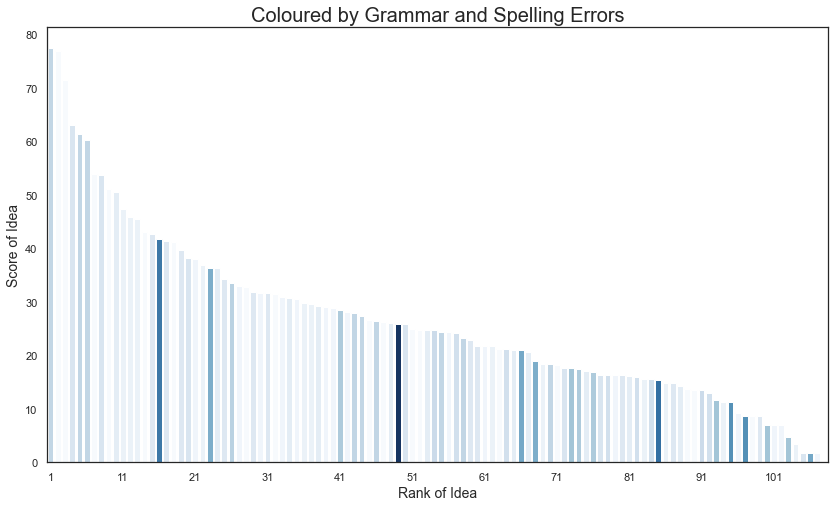

In [123]:
plot_continuous(df = df, x = 'rank', y = 'score', hue = 'mistakes', title = 'Coloured by Grammar and Spelling Errors')

#### Prior Experience
Note: Darker colour more prior experience suggesting ideas

<module 'matplotlib.pyplot' from '/usr/local/Caskroom/miniconda/base/envs/methods3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

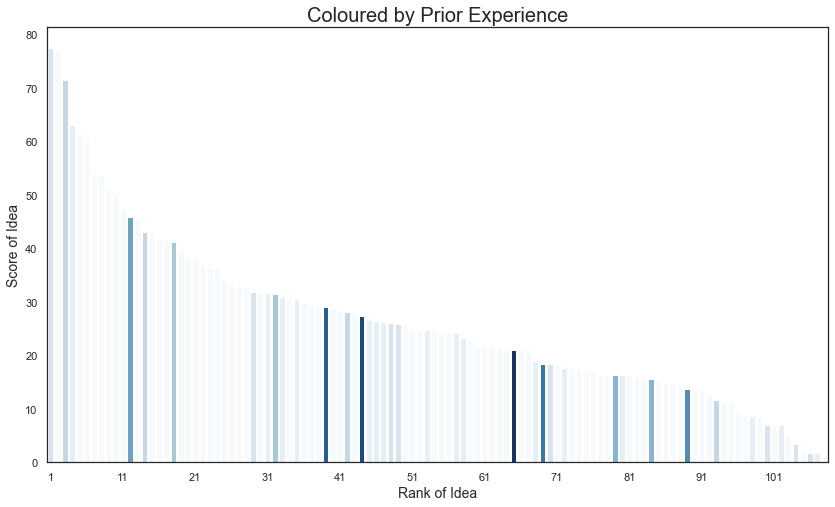

In [124]:
plot_continuous(df = df, x = 'rank', y = 'score', hue = 'prior_experience', title = 'Coloured by Prior Experience')

#### Departments

<module 'matplotlib.pyplot' from '/usr/local/Caskroom/miniconda/base/envs/methods3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

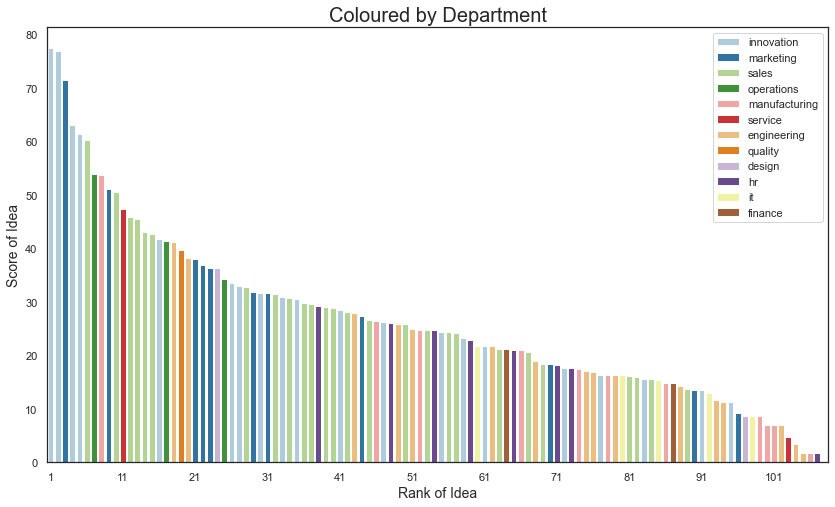

In [125]:
plot_categorical(df = df, x = 'rank', y = 'score', hue = 'department', title = 'Coloured by Department')

#### Locations

<module 'matplotlib.pyplot' from '/usr/local/Caskroom/miniconda/base/envs/methods3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

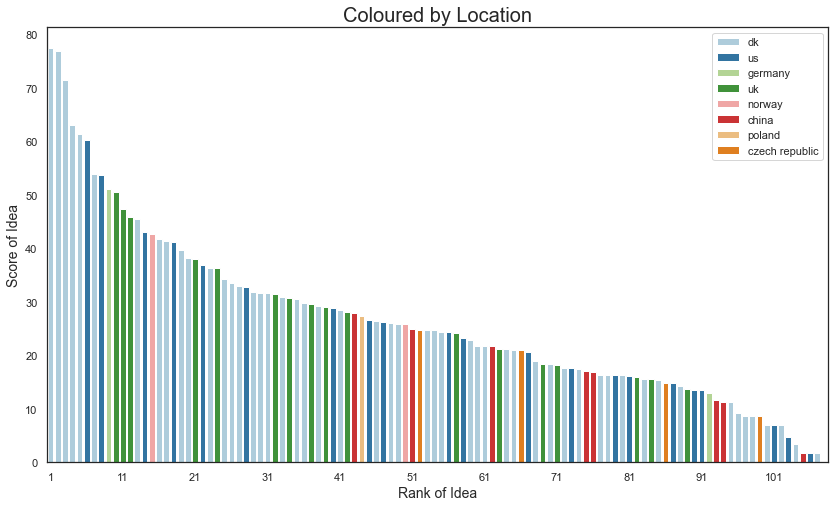

In [126]:
plot_categorical(df = df, x = 'rank', y = 'score', hue = 'location', title = 'Coloured by Location')

The code below exports the dataframe to an excel file. You can use this for further exploration if wanted. 

In [127]:
df.to_excel('output/processed_data.xlsx')